# Проект e-commerce

## Задание

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

## Описание данных

* olist_customers_dataset.csv - таблица с уникальными идентификаторами пользователей

`customer_id` - позаказный идентификатор пользователя <br>

`customer_unique_id` — уникальный идентификатор пользователя (аналог номера паспорта) <br>

`customer_zip_code_prefix` — почтовый индекс пользователя <br>

`customer_city ` — город доставки пользователя <br>

`customer_state ` — штат доставки пользователя <br>

* olist_orders_dataset.csv — таблица заказов

`customer_id` - позаказный идентификатор пользователя <br>

`order_id` — уникальный идентификатор заказа (номер чека) <br>

`order_status` — статус заказа <br>

`order_purchase_timestamp` — время создания заказа <br>

`order_approved_at` — время подтверждения оплаты заказа <br>

`order_delivered_carrier_date` — время передачи заказа в логистическую службу <br>

`order_delivered_customer_date` — время доставки заказа <br> 

`order_estimated_delivery_date` — обещанная дата доставки <br>

* olist_order_items_dataset.csv — товарные позиции, входящие в заказы

`order_id` — уникальный идентификатор заказа (номер чека) <br>

`order_item_id` — идентификатор товара внутри одного заказа <br>

`product_id` — ид товара (аналог штрихкода) <br>

`seller_id` — ид производителя товара <br>

`shipping_limit_date` — максимальная дата доставки продавцом для передачи заказа партнеру по логистике <br>

`price` — цена за единицу товара <br>

`freight_value` — вес товара <br>

## 1. Подготовка данных

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

* Таблица с пользователями

In [14]:
customer_data = pd.read_csv('olist_customers_dataset.csv')
customer_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [15]:
customer_data.shape

(99441, 5)

In [16]:
customer_data.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [17]:
customer_data.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

* Таблица с заказами

In [19]:
order_data = pd.read_csv('olist_orders_dataset.csv', 
                         parse_dates = ['order_purchase_timestamp','order_approved_at',
                                       'order_delivered_carrier_date','order_delivered_customer_date',
                                       'order_estimated_delivery_date'])
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [20]:
order_data.shape

(99441, 8)

In [21]:
order_data.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Отсутствуют значения в следующих столбцах: 

1. `order_approved_at` - отсутствие значения значит, что заказ не оплачен
2. `order_delivered_carrier_date` - отсутствия значения значит, что заказ не передан службе доставки
3. `order_delivered_customer_date` - отсутствие значения значит, что заказ еще не доставлен

In [23]:
order_data.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

* Таблица с товарами в заказах

In [25]:
product_data = pd.read_csv('olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])
product_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [26]:
product_data.shape

(112650, 7)

In [27]:
product_data.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [28]:
product_data.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

## 2. EDA. Что должно считаться покупкой?

In [30]:
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Покупкой считается оплаченный заказ (есть значение в order_approved_at), и имеющие статус заказа "delivered", "shipped", "processing"

Статусы 'invoiced', 'created' и 'approve' не гарантируют дальнейшей оплаты заказа, и что клиент в дальнейшем не откажется от него.

In [32]:
order_data.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Отберём подходящие под определение покупки заказы и присоединим к каждому заказу уникальный идентификатор пользователя (customer_unique_id)

In [34]:
purchases_data = order_data.query('(order_status == "delivered" | order_status == "shipped" | order_status == "processing") & order_approved_at.notna()')

In [35]:
purchases_data = purchases_data.merge(customer_data[['customer_id', 'customer_unique_id']], how = 'left', on = 'customer_id')

In [36]:
purchases_data.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date      303
order_delivered_customer_date    1416
order_estimated_delivery_date       0
customer_unique_id                  0
dtype: int64

## 3. Анализ данных

#### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [39]:
purchases_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


Для начала подсчитаем общее число уникальных пользователей.

In [41]:
count_users = purchases_data.customer_unique_id.nunique()
count_users

94673

In [42]:
count_purchases = purchases_data.groupby('customer_unique_id', as_index = False)\
                  .order_id.count()\
                  .rename(columns = {'order_id':'count_orders'})\
                  .sort_values('count_orders', ascending = False)
count_purchases.head()

,customer_unique_id,count_orders
52180,8d50f5eadf50201ccdcedfb9e2ac8455,16
23125,3e43e6105506432c953e165fb2acf44c,9
37253,6469f99c1f9dfae7733b25662e7f1782,7
74965,ca77025e7201e3b30c44b472ff346268,7
10204,1b6c7548a2a1f9037c1fd3ddfed95f33,7


Число пользователей, совершивших только одну покупку: **91802**

In [44]:
count_purchases.query('count_orders == 1').count().iloc[0]

91802

Для большего понимания того, как много заказов делают пользователи, подсчитаем процент людей совершивших определенное число заказов от всех пользователей.

Более 95% процентов пользователей совершили только одну покупку, по какой-то причине пользователи не возвращаются к продукту.

In [46]:
(round(count_purchases.count_orders.value_counts() / count_users * 100,3)).astype('str') + '%'

count_orders
1     96.967%
2      2.784%
3      0.198%
4      0.031%
5       0.01%
6      0.005%
7      0.003%
16     0.001%
9      0.001%
Name: count, dtype: object

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

Не доставленный заказ = статус заказа 'canceled' либо 'unavailable'

In [49]:
order_data.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [50]:
round(len(order_data.query('order_status == "canceled" | order_status == "unavailable"')) / len(order_data) * 100,2)

1.24

Процент не доставленных заказов от всех заказов = **1.24%**, посмотрим сколько в среднем заказов не доставляется в месяц по разным причинам.

In [52]:
order_data['purchase_month'] = order_data.order_purchase_timestamp.dt.strftime('%Y-%m')

**Причины, по которым заказы не были доставлены** :
1. **Клиент отказался от заказа**

В среднем по этой причине не доставляется 26 заказов в месяц.

In [55]:
order_data[order_data.order_status == 'canceled'].groupby('purchase_month').order_id.count().mean()

26.041666666666668

2. **Заказ недоступен по неизвестной причине (например, потеря на этапе доставки)**

В среднем по этой причине не доставляется 29 заказов в месяц.

In [58]:
order_data[order_data.order_status == 'unavailable'].groupby('purchase_month').order_id.count().mean()

29.0

#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Присоединим данные о товарах к данным о заказах, для ответа на вопрос понадобится дата подтверждения заказа и ID товара.

In [61]:
orders_products = order_data.merge(product_data[['order_id','product_id']], on = 'order_id')[['order_approved_at','product_id']]
orders_products.head()

,order_approved_at,product_id
0,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a
1,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8
2,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415
3,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0
4,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e


Проверим данные на пропуски, если будет пропущена дата подтверждения заказа - строки нужно будет удалить, так как мы не сможем получить день недели без даты.

In [63]:
orders_products.isna().sum()

order_approved_at    15
product_id            0
dtype: int64

In [64]:
orders_products.dropna(inplace = True)

Для каждого заказа укажем день недели

In [66]:
orders_products['purchase_weekday'] = orders_products.order_approved_at.dt.weekday
orders_products.head()

,order_approved_at,product_id,purchase_weekday
0,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,0
1,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,3
2,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,2
3,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,5
4,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,1


С помощью группировки найдем, сколько раз покупался каждый продукт в определенный день недели.

In [68]:
weekday_products = orders_products.groupby(['product_id','purchase_weekday'], as_index = False).purchase_weekday\
                .value_counts()\
                .rename(columns={'count':'weekday_count'})
weekday_products.head()

,product_id,purchase_weekday,weekday_count
0,00066f42aeeb9f3007548bb9d3f33c38,6,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,4,1
3,000b8f95fcb9e0096488278317764d19,2,1
4,000b8f95fcb9e0096488278317764d19,4,1


In [69]:
max_weekday_count = weekday_products.groupby('product_id', as_index = False).weekday_count.max().rename(columns = {'weekday_count':'max_count'})
max_weekday_count = weekday_products.merge(max_weekday_count, how = 'left', on = 'product_id')
max_weekday_count.head()

,product_id,purchase_weekday,weekday_count,max_count
0,00066f42aeeb9f3007548bb9d3f33c38,6,1,1
1,00088930e925c41fd95ebfe695fd2655,1,1,1
2,0009406fd7479715e4bef61dd91f2462,4,1,1
3,000b8f95fcb9e0096488278317764d19,2,1,1
4,000b8f95fcb9e0096488278317764d19,4,1,1


Половина значений максимального количества покупок по дням недели = 1, с большой вероятностью возникнет ситуация, что **у одного товара максимальное количество покупок будет совпадать с покупками по нескольким дням недели**(например: товар купили один раз во вторник и среду, максимальное число покупок товара по дням недели = 1, этому значению соответствует несколько дней недели). Необходимо составить таблицу, которая будет предусматривать такие случаи.

In [71]:
max_weekday_count.max_count.describe()

count    61143.000000
mean         2.674419
std          4.348981
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        119.000000
Name: max_count, dtype: float64

In [72]:
products_max_weekday_count = max_weekday_count.query('weekday_count == max_count').drop(columns=['weekday_count', 'max_count'])
products_max_weekday_count.head()

,product_id,purchase_weekday
0,00066f42aeeb9f3007548bb9d3f33c38,6
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,4
3,000b8f95fcb9e0096488278317764d19,2
4,000b8f95fcb9e0096488278317764d19,4


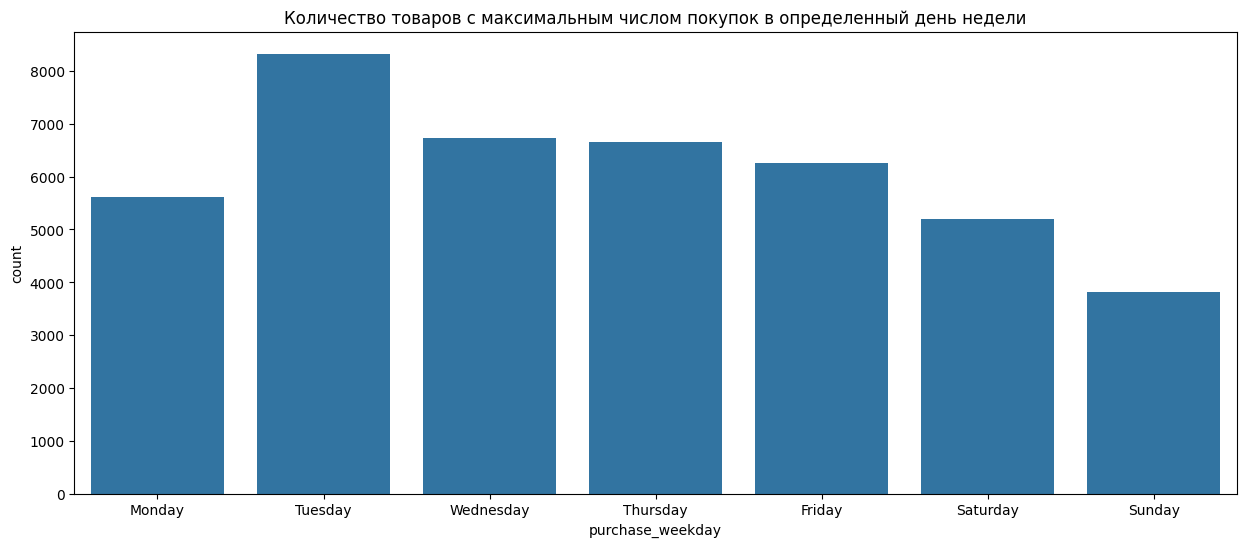

In [73]:
weekdays = ('Monday' , 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
fig,ax = plt.subplots(figsize=(15,6))
plt.title("Количество товаров с максимальным числом покупок в определенный день недели")
sns.countplot(products_max_weekday_count, x = 'purchase_weekday', ax = ax)
ax.set_xticks(np.arange(7),weekdays)
plt.show()

Чаще всего товары покупают во вторник, реже всего в воскресенье

#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Не стоит забывать, что внутри месяца может быть не целое количество недель.

Соберем данные о заказах каждого пользователя вместе с датой подтверждения заказа.

In [78]:
customers_orders = order_data.merge(customer_data, on = 'customer_id', how = 'left')[['customer_unique_id','order_approved_at']]
customers_orders.head()

,customer_unique_id,order_approved_at
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29


Добавим столбцы с месяцем и годом покупки, также необходим столбец с количеством недель в месяце (т.к. внутри месяца может быть не целое количество недель)

In [80]:
customers_orders['order_month'] = customers_orders.order_approved_at.dt.strftime('%Y-%m')

In [81]:
customers_orders.head()

,customer_unique_id,order_approved_at,order_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,2018-02


Сначала получим количество покупок каждого пользователя по месяцам

In [83]:
customers_orders = customers_orders.groupby(['customer_unique_id','order_month'], as_index = False)\
                .order_approved_at.count()\
                .rename(columns={'order_approved_at':'orders_count'})\
                .sort_values('orders_count', ascending = False)
customers_orders.head()

,customer_unique_id,order_month,orders_count
7316,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6
14471,25a560b9a6006157838aab1bdbd68624,2017-04,4
67664,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4
50560,83e7958a94bd7f74a9414d8782f87628,2017-01,4
76689,c8460e4251689ba205045f3ea17884a1,2018-08,4


Добавим столбец с количеством недель в месяце для расчетов среднего числа покупок в неделю, т.к. в месяце может быть не целое число недель.

In [85]:
customers_orders['week_in_month'] = round(pd.to_datetime(customers_orders.order_month).dt.days_in_month / 7, 2)

In [86]:
customers_orders['avg_orders_per_week'] = customers_orders.orders_count / customers_orders.week_in_month

In [87]:
customers_orders.head()

,customer_unique_id,order_month,orders_count,week_in_month,avg_orders_per_week
7316,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.43,1.354402
14471,25a560b9a6006157838aab1bdbd68624,2017-04,4,4.29,0.932401
67664,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4,4.29,0.932401
50560,83e7958a94bd7f74a9414d8782f87628,2017-01,4,4.43,0.902935
76689,c8460e4251689ba205045f3ea17884a1,2018-08,4,4.43,0.902935


#### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

Для начала необходимо определиться с периодом, найдем год, в котором присутствуют данные о покупках с января по декабрь.

In [90]:
order_data.order_approved_at.dt.strftime('%Y-%m').sort_values().drop_duplicates()

30710    2016-09
89768    2016-10
39761    2016-12
73647    2017-01
20203    2017-02
73915    2017-03
45768    2017-04
65486    2017-05
68758    2017-06
61864    2017-07
44275    2017-08
45839    2017-09
87935    2017-10
59030    2017-11
49303    2017-12
16131    2018-01
70652    2018-02
70812    2018-03
13970    2018-04
6912     2018-05
56845    2018-06
69729    2018-07
98045    2018-08
62360    2018-09
1130         NaN
Name: order_approved_at, dtype: object

In [91]:
customer_data.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Под условие подходит только 2017 год => Retention будет проводиться по месяцам 2017 года.

Считается, что пользователь вернулся, если он совершил покупку в месяце, по которому считается Retention.

Определим принадлежность пользователя к определенной когорте по месяцу, в котором он совершил первую покупку. 

In [95]:
customers_orders = order_data.merge(customer_data, on = 'customer_id', how = 'left')[['customer_unique_id','order_approved_at']]
customers_orders['order_approved_at'] = pd.to_datetime(customers_orders.order_approved_at.dt.strftime('%Y-%m'))
customers_orders = customers_orders.query("order_approved_at.astype('str').str.startswith('2017')")
customers_orders.head()

,customer_unique_id,order_approved_at
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01
3,7c142cf63193a1473d2e66489a9ae977,2017-11-01
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-01
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-01
7,932afa1e708222e5821dac9cd5db4cae,2017-05-01


In [96]:
customers_cohorts = customers_orders.groupby('customer_unique_id', as_index = False)\
                                    .order_approved_at.min()\
                                    .rename(columns={'order_approved_at':'cohort'})
customers_cohorts

,customer_unique_id,cohort
0,0000f46a3911fa3c0805444483337064,2017-03-01
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
2,0004aac84e0df4da2b147fca70cf8255,2017-11-01
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-01
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-01
...,...,...
43597,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-01
43598,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01
43599,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01
43600,ffff371b4d645b6ecea244b27531430a,2017-02-01


Проверим, что когорты отобрались только для 2017 года

In [98]:
customers_cohorts.cohort.describe()

count                            43602
mean     2017-07-30 19:24:23.877804032
min                2017-01-01 00:00:00
25%                2017-05-01 00:00:00
50%                2017-08-01 00:00:00
75%                2017-11-01 00:00:00
max                2017-12-01 00:00:00
Name: cohort, dtype: object

In [99]:
cohort_retention = customers_orders.merge(customers_cohorts, on = 'customer_unique_id', how = 'left').dropna()
cohort_retention['retention_month'] = cohort_retention.order_approved_at.dt.month - cohort_retention.cohort.dt.month
cohort_retention['cohort'] = cohort_retention['cohort'].astype('str')
cohort_retention.head()

,customer_unique_id,order_approved_at,cohort,retention_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,2017-09-01,1
1,7c142cf63193a1473d2e66489a9ae977,2017-11-01,2017-11-01,0
2,80bb27c7c16e8f973207a5086ab329e2,2017-07-01,2017-07-01,0
3,36edbb3fb164b1f16485364b6fb04c73,2017-04-01,2017-04-01,0
4,932afa1e708222e5821dac9cd5db4cae,2017-05-01,2017-05-01,0


Теперь для каждой когорты пользователей построим таблицу с процентом retention по месяцам 2017 года.

In [101]:
retention_table = pd.pivot_table(cohort_retention, index = 'cohort', columns = 'retention_month', values = 'customer_unique_id', aggfunc = "count")
retention_table = retention_table.divide(retention_table[0], axis = 0)
retention_table

retention_month,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01-01,1.0,0.005263,0.002632,0.001316,0.003947,0.001316,0.005263,0.001316,0.001316,NaN,0.002632,0.002632
2017-02-01,1.0,0.002271,0.002271,0.001704,0.003975,0.001136,0.002271,0.001704,0.001136,0.002271,0.001136,NaN
2017-03-01,1.0,0.005218,0.003354,0.004100,0.003354,0.001491,0.001491,0.002982,0.002982,0.001118,NaN,NaN
2017-04-01,1.0,0.006369,0.002548,0.002123,0.002972,0.002548,0.003822,0.002548,0.003397,NaN,NaN,NaN
2017-05-01,1.0,0.005460,0.005733,0.003822,0.003003,0.004095,0.004641,0.001638,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.004677,0.003742,0.004054,0.002495,0.003430,0.003742,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.0,0.005615,0.003318,0.002042,0.003828,0.001787,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,1.0,0.006536,0.003968,0.002568,0.003735,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,1.0,0.006395,0.004737,0.004263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Purchases retention 2017 \n'}, xlabel='retention_month', ylabel='cohort'>

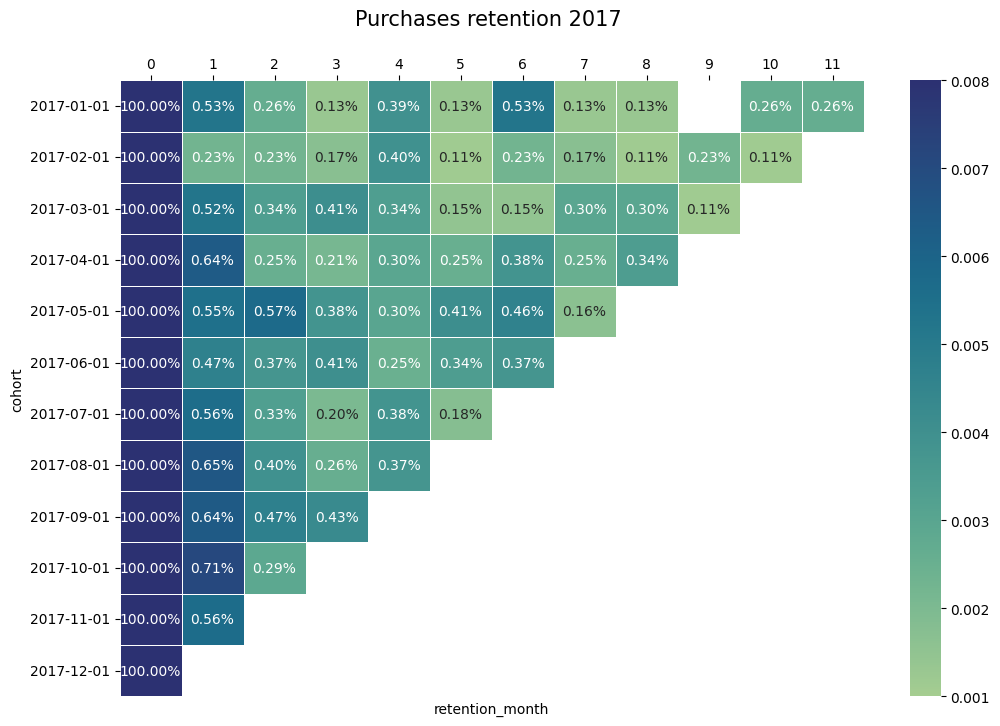

In [102]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Purchases retention 2017 \n', fontsize = 15)
ax.xaxis.tick_top()
sns.heatmap(retention_table, vmin = 0.001, vmax = 0.008, annot = True, linewidth = 0.5, fmt = '.2%', cmap = 'crest')

В период с января по декабрь когорта с самым высоким retention на 3й месяц: 2017-06-01

Для всех когорт общая тенденция: retention резко падает до < 1% на следующий месяц после первой покупки и далее не повышается. Можно сделать вывод, что большинство пользователей совершает только одну покупку.

#### 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

* Recency - время от последней покупки пользователя до текущей даты (т.к. данные старые, текущей датой будем считать последнюю дату среди всех заказов)

* Frequency - суммарное количество покупок у пользователя за всё время

* Monetary - сумма покупок пользователя за всё время

Соединим пользователей с их заказами и ценами товаров в них

In [110]:
customers_segments = order_data.merge(customer_data, on = 'customer_id', how = 'left')[['customer_unique_id','order_approved_at','order_id']]
customers_segments = customers_segments.merge(product_data[['order_id','price']], how = 'left', on = 'order_id')
customers_segments = customers_segments.groupby(['customer_unique_id','order_id'], as_index = False).agg({'order_approved_at': "max", 'price' : "sum"})
customers_segments.dropna(inplace = True)
customers_segments

,customer_unique_id,order_id,order_approved_at,price
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 11:11:18,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 18:25:44,18.90
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:49:17,25.99
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 20:06:52,180.00
...,...,...,...,...
99436,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:15:16,1570.00
99437,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:16:20,64.89
99438,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 16:02:44,89.90
99439,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02 15:58:47,115.00


Для каждого пользователя рассчитаем его значения Recency, Frequency и Monetary

In [111]:
current_date = customers_segments.order_approved_at.max()
current_date

Timestamp('2018-09-03 17:40:06')

In [112]:
customers_stat = customers_segments.groupby('customer_unique_id', as_index = False)\
                                   .agg({'order_approved_at' : lambda x: int((current_date - x.max()).days), 
                                         'order_id' : 'count',
                                         'price' : 'sum'})
customers_stat = customers_stat.rename(columns = {'order_approved_at' : 'recency', 'order_id' : 'frequency', 'price' : 'monetary'})
customers_stat.head()


,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
2,0000f46a3911fa3c0805444483337064,541,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00


#### Выделение кластеров по Recency

In [113]:
customers_stat.recency.describe()

count    95997.000000
mean       243.250904
std        153.282280
min          0.000000
25%        119.000000
50%        224.000000
75%        353.000000
max        718.000000
Name: recency, dtype: float64

<Axes: xlabel='recency', ylabel='Count'>

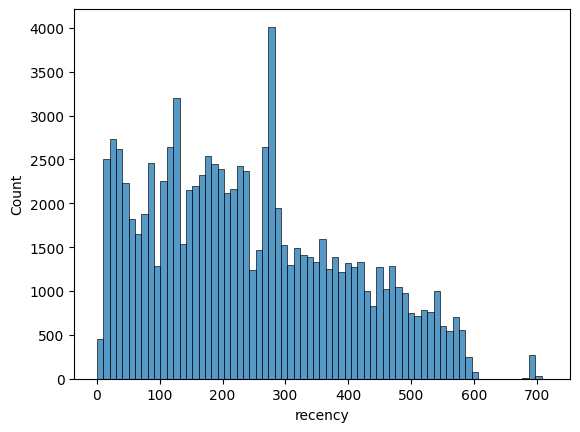

In [178]:
sns.histplot(customers_stat.recency)

Кластера для recency можно выделить по квартилям:

1 кластер: последняя покупка менее 120 дней назад <br>
2 кластер: последняя покупка от 120 до 224 дней назад <br>
3 кластер: последняя покупка более 224 дней назад <br>

#### Выделение кластеров по Frequency

In [114]:
customers_stat.frequency.describe()

count    95997.000000
mean         1.034209
std          0.212521
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: frequency, dtype: float64

Большинство пользователей совершают всего одну покупку, поэтому целесообразно выделить всего два кластера

1 кластер: пользователь совершил более чем 1 покупку <br>
2 кластер: пользователь совершил только 1 покупку

Пользователей из 1 кластера всего 3% от общего числа пользователей, можно считать их лояльными к продукту.

In [256]:
customers_stat.query('frequency > 1').shape[0] / len(customers_stat) * 100

3.0709292998739546

#### Выделение кластеров по Monetary

In [115]:
customers_stat.monetary.describe()

count    95997.000000
mean       141.566646
std        217.282723
min          0.000000
25%         46.400000
50%         89.000000
75%        154.170000
max      13440.000000
Name: monetary, dtype: float64

In [279]:
maxi = customers_stat.monetary.quantile(0.975)

<Axes: xlabel='monetary', ylabel='Count'>

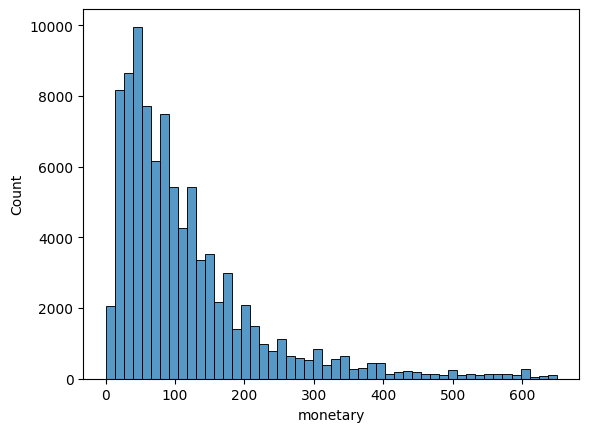

In [283]:
sns.histplot(customers_stat.query('monetary < @maxi').monetary, bins = 50)

Распределение monetary подходит для деления по квартилям.

1 кластер: общая сумма покупок > 155 <br>
2 кластер: 89 < общая сумма покупок <= 155 <br>
3 кластер: 46 < общая сумма покупок <= 89 <br>
4 кластер: общая сумма покупок <= 46 <br>

Разделим пользователей по RFM-сегментам

In [301]:
def set_recency_cluster(recency):
    if recency < 120:
        return 1
    if recency <= 224:
        return 2
    else:
        return 3

def set_frequency_cluster(frequency):
    if frequency > 1:
        return 1
    else:
        return 2

def set_monetary_cluster(monetary):
    if monetary <= 46:
        return 4
    if monetary <= 89:
        return 3
    if monetary <= 155:
        return 2
    else:
        return 1

In [305]:
customers_stat['R_cluster'] = customers_stat['recency'].apply(set_recency_cluster)
customers_stat['F_cluster'] = customers_stat['frequency'].apply(set_frequency_cluster)
customers_stat['M_cluster'] = customers_stat['monetary'].apply(set_monetary_cluster)

In [317]:
customers_stat['RFM_class'] = customers_stat['R_cluster'].astype('str') + customers_stat['F_cluster'].astype('str') + customers_stat['M_cluster'].astype('str')

Оценка классов варьируется от 111 - лучший по RFM параметрам к 324 - худший.

In [319]:
customers_stat.head()

,customer_unique_id,recency,frequency,monetary,R_cluster,F_cluster,M_cluster,RFM_class
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,2,2,122
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,1,2,4,124
2,0000f46a3911fa3c0805444483337064,541,1,69.00,3,2,3,323
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,3,2,4,324
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,3,2,1,321


Рассмотрим получившиеся классы детальнее

In [372]:
rfm_table = customers_stat.groupby('RFM_class', as_index = False).customer_unique_id.count()\
               .rename(columns={'customer_unique_id' : 'count_users'})\
               .sort_values('count_users', ascending = False)
rfm_table['percent'] = round(rfm_table.count_users / len(customers_stat) * 100,2)
rfm_table.head()

,RFM_class,count_users,percent
22,323,11997,12.50
23,324,11984,12.48
21,322,11389,11.86
20,321,11088,11.55
13,222,6032,6.28


C:\Users\фвьшт\AppData\Local\Temp\ipykernel_16404\3432453499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(rfm_table, x = 'RFM_class', y = 'percent', palette = 'flare')


<Axes: title={'center': 'Percentage of each RFM class'}, xlabel='RFM_class', ylabel='percent'>

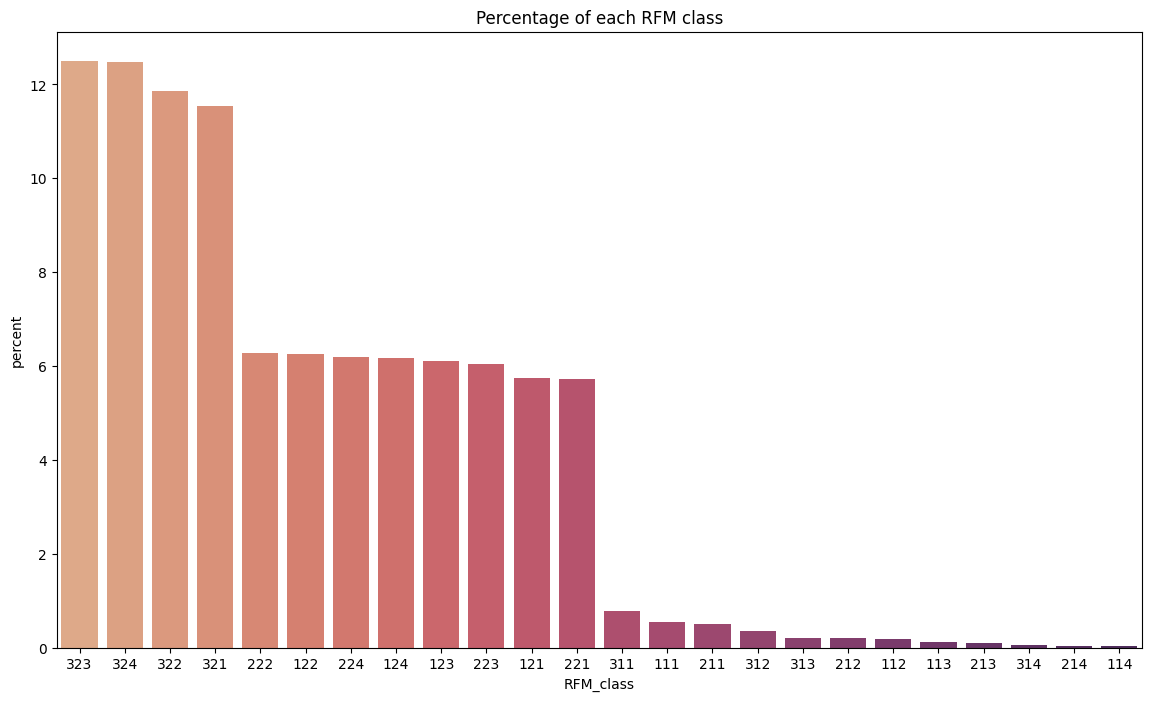

In [370]:
fig,ax = plt.subplots(figsize=(14,8))
plt.title('Percentage of each RFM class')
sns.barplot(rfm_table, x = 'RFM_class', y = 'percent', palette = 'flare')

**Самые популярные классы:** <br>
1. `323` - совершили одну недорогую покупку более чем 225 дней назад
2. `324` - совершили одну дешевую покупку более чем 225 дней назад, худший класс
3. `322` - совершили одну покупку до 155 долларов более чем 225 дней назад
4. `321` - совершили одну дорогую покупку более чем 225 дней назад
5. `222` - совершили одну покупку до 155 долларов от 120 до 225 дней назад

К сожалению, самые популярные классы состоят из пользователей, которые совершили только одну покупку и больше не возвращались к продукту длительное время.

**Классы, на которые стоит обратить внимание:**

1. Все классы, у которых F = 1 и R != 4, это менее чем 3% пользователей, которые совершили повторную покупку и еще не до конца "отвалились", их необходимо сохранить. Самый лояльный класс - `111`
2. `121` - совершили дорогую первую покупку менее чем 120 дней назад, есть шанс конвертировать их в лояльных пользователей с высокими тратами
3. `122`,`123`, `124` - совершили первую покупку менее чем 120 дней назад, но на небольшую сумму, есть шанс конвертировать их в лояльных пользователей